# Calculate cross correlation functions from raw noise data in SAC

In this notebook, we show some of the key steps in NoisePy for computing cross correlation functions in order for you better understand the unerlying processes of NoisePy script of S1. The input data are daily noise data recorded by two stations and here we show examples in SAC format. 

The steps to compuate cross correlation functions are:    
* Load SAC data and the header info into memory
* Break the continous data into small segments with overlaps
* Perform Fourier Transform to convert signals into frequency-domain
* Calculate cross correlation functions between the small time segments and choose to stack (substack) the cross correlation function of each segment and return to time domain
* Save the function in an ASDF file

More details on the descriptions of data processing, parameters for different cross correlation method and performance of NoisePy can be found in the online [documentations](https://noise-python.readthedocs.io/en/latest/) and our paper.

`Jiang, C. and Denolle, M. 2020. NoisePy: a new high-performance python tool for seismic ambient noise seismology. _Seismological Research Letter_. 91, 1853-1866`



Chengxin Jiang & Marine Denolle

Department of Earth and Planetary Science

Harvard University

November 2019

## Building env for NoisePy

Before running this notebook, make sure that you have created and activated the conda env made for NoisePy. If not, you can create one using command lines below (note that jupyter is installed with the command lines here in order to run this notebook). 

```python
conda create -n noisepy -c conda-forge python=3.7 numpy=1.16.2 numba pandas pycwt jupyter mpi4py=3.0.1 obspy=1.1 pyasdf
conda activate noisepy
```

Then you need to activate this notebook with the newly built NoisePy env by invoking the jupyter with the following command line.

```python
jupyter notebook
```

Now we can begin to load the modules needed for this practise. 

In [1]:
import os
import sys
import glob
import obspy
import scipy
import pyasdf
import numpy as np
import matplotlib.pyplot as plt 

sys.path.insert(1,'../src')
import noise_module

## 1. Setup basic parameters

The fundamental step is to setup the parameters used for cross correlation. As you can find from section below, there are many parameters needed for the computation, which are associated with the input data, some details controlling the targeted processing procedures and some tuning parameters. Some brief descriptions of the parameters are included here following the definination, but note that more details on this can be found in documentations.  

In [2]:
sfiles = glob.glob('/Users/iotsoftwareengineer/cross-correlation-noisepy/2 stasiun 1 component/*.SAC')      # find sac files
if len(sfiles)<2:
    raise ValueError('Abort! At least 2 sac files are needed!')
outpath = './'                     # output dir

# parameters of fft_cc
cc_len    = 4000                    # window length (sec) to cut daily data into small segments
step      = 450                     # overlapping (sec) between the sliding window
smooth_N  = 10                      # number of points to be smoothed for running-mean average (time-domain)
dt        = 0.05                    # sampling time intervals of the data: in real case it reads from data directly
samp_freq = int(1/dt)               # sampling rate 
inc_hours = 24                      # basic length (hour) of the continous noise data        
freqmin   = 0.01                     # frequency range
freqmax   = 10            

freq_norm   = 'rma'                 # rma-> running mean average for frequency-domain normalization
time_norm   = 'no'                  # no-> no time-domain normalization; other options are 'rma' for running-mean and 'one-bit'
cc_method   = 'xcorr'               # xcorr-> pure cross correlation; other option is 'decon'
substack       = False              # sub-stack daily cross-correlation or not
substack_len   = cc_len             # how long to stack over: need to be multiples of cc_len
smoothspect_N  = 10                 # number of points to be smoothed for running-mean average (freq-domain)

# cross-correlation parameters
maxlag       = 100                  # time lag (sec) for the cross correlation functions
max_over_std = 10                   # amplitude therahold to remove segments of spurious phases 

# group parameters into a dict
fc_para={'samp_freq':samp_freq,'dt':dt,'cc_len':cc_len,'step':step,'freq_norm':freq_norm,'time_norm':time_norm,\
    'cc_method':cc_method,'maxlag':maxlag,'max_over_std':max_over_std,'inc_hours':inc_hours,'smooth_N':smooth_N,\
    'freqmin':freqmin,'freqmax':freqmax,'smoothspect_N':smoothspect_N,'substack':substack,\
    'substack_len':substack_len}

## 2. Load source data

In [6]:
# read source and some meta info

tr_source = obspy.read(sfiles[0])
print(tr_source, '\n')
slon = tr_source[0].stats.sac['stlo'] #source longitude
print(slon, '\n')
slat = tr_source[0].stats.sac['stla'] #source latitude
print(slat, '\n')

# cut source traces into small segments and make statistics
trace_stdS,dataS_t,dataS = noise_module.cut_trace_make_stat(fc_para,tr_source)

# do fft to freq-domain
print("dataS: ", dataS)
source_white = noise_module.noise_processing(fc_para,dataS)
print(source_white, "source_white")
source_white = np.conjugate(source_white)
print(" source_white: ",source_white)

# num of frequency data
Nfft = source_white.shape[1];Nfft2 = Nfft//2
print(" Nfft: ",Nfft)

# find the right index of good signals
sou_ind = np.where((trace_stdS<max_over_std)&(trace_stdS>0)&(np.isnan(trace_stdS)==0))[0]

1 Trace(s) in Stream:
MX.AFB..BHE | 2004-07-20T00:00:00.000000Z - 2004-07-21T00:00:00.000000Z | 10.0 Hz, 864001 samples 

109.77509 

-7.62696 

dataS:  [[  0.          0.         -0.        ...   0.         -0.
   -0.       ]
 [  0.          0.         -0.        ...   0.         -0.
   -0.       ]
 [  0.          0.         -0.        ...   0.         -0.
   -0.       ]
 ...
 [  0.         -0.5207414 -11.673114  ...  58.441315   13.481705
    0.       ]
 [  0.          9.768849   24.140825  ...  76.010155   18.829933
    0.       ]
 [  0.         25.624344   93.12447   ...  51.37841     9.721543
    0.       ]]
[[ 0.0000000e+00+0.0000000e+00j  3.7493994e-33+0.0000000e+00j
   7.5961235e-03+0.0000000e+00j ...  3.0153690e-02-0.0000000e+00j
   7.5961235e-03-0.0000000e+00j  3.7493994e-33-0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  3.7493994e-33+0.0000000e+00j
   7.5961235e-03+0.0000000e+00j ...  3.0153690e-02-0.0000000e+00j
   7.5961235e-03-0.0000000e+00j  3.7493994e-33-0.0000000e+00

## 3. Load receiver data

In [15]:
# read receiver and some meta info
tr_receiver = obspy.read(sfiles[1])
print(tr_receiver, "tr_receiver")
rlon = tr_receiver[0].stats.sac['stlo']
print(rlon, '\n')
rlat = tr_receiver[0].stats.sac['stla']
print(rlat, '\n')

# work out distance between source and receiver
dist,azi,baz = obspy.geodetics.base.gps2dist_azimuth(slat,slon,rlat,rlon)
print(dist, "dist")
print(azi, "azi")

# cut source traces into small segments and make statistics
trace_stdR,dataR_t,dataR = noise_module.cut_trace_make_stat(fc_para,tr_receiver)

# do fft to freq-domain
receiver_white = noise_module.noise_processing(fc_para,dataR)

# find the right index of good signals
rec_ind = np.where((trace_stdR<max_over_std)&(trace_stdR>0)&(np.isnan(trace_stdR)==0))[0]

1 Trace(s) in Stream:
MX.DEB..BHE | 2004-07-20T00:00:00.000000Z - 2004-07-21T00:00:00.000000Z | 10.0 Hz, 864001 samples tr_receiver
109.73565 

-7.03357 

65768.76067374504 dist
356.200538518839 azi


## 4. Perform cross correlation

4001


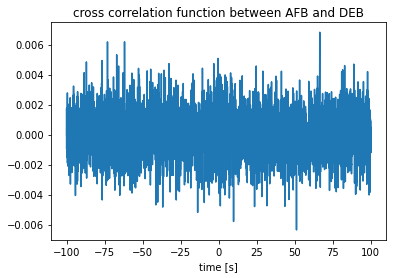

In [8]:
# find the segments of good data for both source and receiver
bb=np.intersect1d(sou_ind,rec_ind)
if len(bb)==0:raise ValueError('Abort! no good data in overlap')

# do cross correlation
corr_day,t_corr,n_corr = noise_module.correlate(source_white[bb,:Nfft2],receiver_white[bb,:Nfft2],fc_para,Nfft,dataS_t)

# plot the waveform
print(len(corr_day))
tvec = np.arange(-maxlag,maxlag+dt,dt)
plt.figure()
plt.plot(tvec,corr_day)
plt.xlabel('time [s]')
plt.title('cross correlation function between AFB and DEB')
plt.show()

## 5. Save cross correlation data into ASDF file

Though we only have one station pair, we can try to save it into the ASDF file. We save the cross correlation data into the auxiliary structure of ASDF, which has two dimentions (data_type and path). In this example, we use the station and network name of the source and receiver station to define the $data\_type$ and use the channel names to define the $path$. The two tags are chose because the two-dimention variable are enough to define any cross component of the cross correlation functions for any station pairs. 

In [9]:
cc_h5 = './CCF/Data Stasiun.h5'         
with pyasdf.ASDFDataSet(cc_h5,mpi=False,mode='w') as ccf_ds:
    # location info 
    coor = {'lonS':slon,'latS':slat,'lonR':rlon,'latR':rlat}
    # cross component
    comp = tr_source[0].stats.channel[-1]+tr_receiver[0].stats.channel[-1]
    # parameters to be saved into ASDF
    parameters = noise_module.cc_parameters(fc_para,coor,t_corr,n_corr,comp)

    # data_type name as source-receiver pair
    data_type = tr_source[0].stats.network+'.'+tr_source[0].stats.station+'_'+tr_receiver[0].stats.network+'.'+tr_receiver[0].stats.station
    # path name as cross component
    path = comp
    # command to save data and parameters into asdf structure
    ccf_ds.add_auxiliary_data(data=corr_day, data_type=data_type, path=path, parameters=parameters)


## 6. Read the ASDF file

Finally, we want to read the cross correlation function we just saved. To retrive the data, we simply need the two tags we just created for the auxiliary structure in ASDF, which are $data\_type$ and $path$. Note that we do not necessarily need to know the two parameters beforehand, because we can simply get the two parameters from reading the file. You will see how we do it from the codes below.  

['MX.AFB_MX.DEB'] ['EE']
[-9.1104390e-04  1.7497286e-03 -8.7581582e-05 ...  1.9880246e-05
 -1.2105450e-03  4.6576612e-04] {'azi': 356.20053, 'baz': 176.20557, 'cc_method': 'xcorr', 'comp': 'EE', 'dist': 65.76876, 'dt': 0.05, 'latR': -7.03357, 'latS': -7.62696, 'lonR': 109.73565, 'lonS': 109.77509, 'maxlag': 100, 'ngood': 129, 'substack': False, 'time': 1090281600.0}
[-9.1104390e-04  1.7497286e-03 -8.7581582e-05 ...  1.9880246e-05
 -1.2105450e-03  4.6576612e-04] data
{'azi': 356.20053, 'baz': 176.20557, 'cc_method': 'xcorr', 'comp': 'EE', 'dist': 65.76876, 'dt': 0.05, 'latR': -7.03357, 'latS': -7.62696, 'lonR': 109.73565, 'lonS': 109.77509, 'maxlag': 100, 'ngood': 129, 'substack': False, 'time': 1090281600.0} para


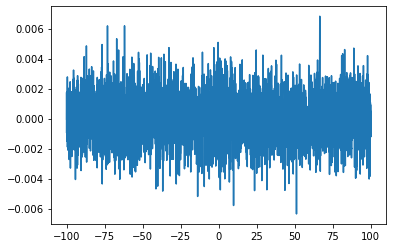

In [12]:
with pyasdf.ASDFDataSet(cc_h5,mode='r') as ds:
    data_type = ds.auxiliary_data.list()
    path = ds.auxiliary_data[data_type[0]].list()
    print(data_type,path)
    
    data = ds.auxiliary_data[data_type[0]][path[0]].data[:]
    para = ds.auxiliary_data[data_type[0]][path[0]].parameters
    print(data,para)
    print(data, "data")
    print(para, "para")
    
    # plot the waveform again
    plt.plot(tvec,data)

## The end.

Please check the notebook of download_toASDF_cross_correlation.ipynb for how to start from noise data that are stored in ASDF file that is created using S0 of NoisePy. 

In [11]:
import pyasdf
ds = pyasdf.ASDFDataSet("./CCF/Data Stasiun.h5")
print(ds.events)
type(ds.events)

0 Event(s) in Catalog:



obspy.core.event.catalog.Catalog